# Face Detection and Recognition CNN Models

Author: Luca Franceschi (u199149)

In this notebook we will try to construct two CNN models, one for face boundary detection and another for face recognition. The intention for the Coding Challenge 3 is to: with each image first detect if there is a face or not, in case there is, detect the boundaries. Then we can crop the image with the calculated boundaries and pass it to the recognition model to be able to recognize if the face exists in the dataset or is an impostor.

In [319]:
import torch
import scipy.io
import torch.jit
import numpy as np
from torch import nn
from PIL import Image
import torch.optim as optim
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import random_split
from torchvision.transforms.functional import get_image_size

In [320]:
# Hyperparameters
lr = 0.0005                 # Learning rate
epochs = 101                # Total number of epochs
batch_size = 32             # The sizes in which the dataset is split to feed the networks
det_resized = (224, 224)    # The normalized size of the images in the detection model
rec_resized = det_resized   # The normalized size of the images in the recognition model

# Other parameters
epoch_step = 5              # Frequency in which epoch losses are printed on training
images_path = './TRAINING/' # Relativ# train_mean, train_std = compute_mean_std(det_train_data)e path to the training dataset
target_matrix_path = ''     # Relative path to the "AGC_Challenge3_Training.mat" file

In [321]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the target matrix

When loading the matrix we can import either the boundaries or the identity. 
- For the detection network we will import the Image name along with the boundaries. In case there is a face (or more) the first position in the boundaries will be the amount of faces in that image. In case there is no faces, that parameter will be 0 and the boundaries will be a "padding" of zeros. The imported data in this case will look like: ```[name, [#faces, x0, y0, x1, y1]]```, very similar as in previous labs. In case there are more than one face the first one in the matrix will be considered.
- For the recognition network we will import the image name along with the id and its boundaries. If the id is -1 it is imported as 0 to fix some out of bounds error. This is corrected in the output of the model and is transparent to the user.

In [322]:
def load_data(labels_path, labels_wanted='boundaries'):
    mat = scipy.io.loadmat(labels_path)['AGC_Challenge3_TRAINING'][0]
    data = []
    for entry in mat:
        key = entry[1][0]
        if (len(entry[2]) > 0):
            boundary = np.array(entry[2][0], dtype=np.int32)
            if (labels_wanted == 'boundaries'):
                data.append([key, boundary])
            elif (labels_wanted == 'identity'):
                if (entry[0][0][0] == -1):
                    data.append([key, 0, boundary])
                else:
                    data.append([key, entry[0][0][0], boundary])

    return data

In [323]:
# mean and std extracted from the train_dataset part of AGC_Challenge3_TRAINING
def compute_mean_std(dataset):
    image_count = len(dataset)
    images = np.zeros((image_count, rec_resized[0], rec_resized[1], 3))
    for i, (image_path, _) in enumerate(dataset):
        with Image.open(images_path + image_path) as image:
            image = image.resize(det_resized)
            image = image.convert('RGB')
            image_array = np.array(image)
            images[i] = image_array

    mean = np.mean(images, axis=(0, 1, 2)) / 255.0
    std_dev = np.std(images, axis=(0, 1, 2)) / 255.0

    return mean, std_dev

In [324]:
detection_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat')
recognition_data = load_data(target_matrix_path + 'AGC_Challenge3_Training.mat', 'identity')

m, s = compute_mean_std(detection_data)
print(m, s)

# data_mean = [0.485, 0.456, 0.406]
# data_std = [0.229, 0.224, 0.225]

data_mean = m
data_std = s

[0.48464295 0.4219926  0.39299254] [0.32095764 0.30016821 0.29993387]


## The Transforms

In [325]:
det_tr_transform = transforms.Compose([
    # transforms.Resize(300, 300),
    transforms.RandomResizedCrop(det_resized),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    # transforms.Normalize(mean=train_mean, std=train_std)
    transforms.Normalize(mean=data_mean, std=data_std)
])

det_base_transform = transforms.Compose([
    transforms.Resize(det_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_tr_transform = transforms.Compose([
    transforms.RandomResizedCrop(rec_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

rec_val_transform = transforms.Compose([
    transforms.Resize(rec_resized),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

## The Convolutional Neural Network Class

In [326]:
class CNN(nn.Module):
    def __init__(self, cnn_layers, fc_layers, type):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = cnn_layers
        self.fc_layers = fc_layers
        self.cnn_type = type

    def forward(self, data):
        output = self.cnn_layers(data)
        output = self.flatten(output) # before linear layer !!!
        output = self.fc_layers(output)
        return output

    def fit(self, training_data, loss_fn, optimizer: optim.Optimizer):
        self.train()
        total_loss = 0.0

        for batch_data, target in training_data:
            batch_data = batch_data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            output = self.forward(batch_data)
            
            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)
                
            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(training_data)

    def evaluate(self, validation_data, loss_fn):
        self.eval()
        total_loss = 0.0

        for batch_data, target in validation_data:
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            output = self.forward(batch_data)

            if self.cnn_type == 'detection':
                pass
            elif self.cnn_type == 'recognition':
                target = target.type(torch.long)

            loss = loss_fn(output, target)

            total_loss += loss.item()

            # Compute accuracy
            # _, predicted = torch.max(output, 1)
            # total_predictions += labels.size(0)
            # correct_predictions += (predicted == labels).sum().item()

        # average_loss = total_loss / len(validation_data)
        # accuracy = correct_predictions / total_predictions

        return total_loss / len(validation_data)

    def predict(self, test_image):
        self.eval()
        with torch.inference_mode(mode=True):
            test_image = test_image.convert('RGB')
            w, h = get_image_size(test_image)
            if self.cnn_type == 'detection':
                test_image = det_base_transform(test_image)
                # test_image = torch.tensor(test_image, dtype=torch.float32)
                output = self.forward(test_image.unsqueeze(0))[0]
                # print(output)
                # output = [output[0], output[1]*w/det_resized[0], output[2]*h/det_resized[1], output[3]*w/det_resized[0], output[4]*h/det_resized[1]]
                output = [output[0]*w/det_resized[0], output[1]*h/det_resized[1], output[2]*w/det_resized[0], output[3]*h/det_resized[1]]
                # print(output)
                return output
            elif self.cnn_type == 'recognition':
                test_image = rec_val_transform(test_image)
                output = self.forward(test_image.unsqueeze(0))
                output = np.argmax(output)
                if output == 0:
                    return -1
                return int(output)
            
    def training_loop(self, training_loader, val_loader, epochs, loss_fn, lr):
        tr_losses = []
        val_losses = []
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs')
        for epoch in range(epochs):
            tr_losses.append(self.fit(training_loader, loss_fn, optimizer))
            loss = self.evaluate(val_loader, loss_fn)
            val_losses.append(loss)
            scheduler.step(loss)

            if epoch % epoch_step == 0:
                print(f'Epoch {epoch} has loss {val_losses[epoch]}')
        
        return tr_losses, val_losses

## The Detection Model

### The Data

In [327]:
class DetectionData(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        with Image.open(images_path + image_name) as image:
            # Apply transformations if specified
            image = image.convert('RGB')
            w, h = get_image_size(image)
            if self.transform:
                image = self.transform(image)
            # image = torch.tensor(image, dtype=torch.float32)

            # label = [label[0], label[1]/w*det_resized[0], label[2]/h*det_resized[1], label[3]/w*det_resized[0], label[4]/h*det_resized[1]]
            label = [label[0]/w*det_resized[0], label[1]/h*det_resized[1], label[2]/w*det_resized[0], label[3]/h*det_resized[1]]
            label = torch.tensor(label, dtype=torch.float32)
            label = torch.flatten(label)
            return image, label

In [328]:
det_train_data, det_val_data, det_test_data = random_split(detection_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset = DetectionData(det_train_data, det_tr_transform)
val_dataset = DetectionData(det_val_data, det_base_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### The Layers

In [329]:
detection_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
detection_fc_layers = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(25088, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(32, 4)
)

### Model creation and training

In [330]:
detection = CNN(detection_cnn_layers, detection_fc_layers, 'detection').to(device)
print(detection)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Batch

In [331]:
# detection.load_state_dict(torch.load('detection_model.pt'))

In [332]:
print(sum(p.numel() for p in detection.parameters()))

900900


In [333]:
# train loop as train and then test
loss = nn.MSELoss()

det_tr_losses, det_val_losses = detection.training_loop(train_loader, val_loader, epochs, loss, lr)

Epoch 0 has loss 7884.1953125
Epoch 5 has loss 728.708984375
Epoch 10 has loss 763.990234375
Epoch 15 has loss 716.4725646972656
Epoch 20 has loss 675.7103881835938
Epoch 25 has loss 598.2959442138672
Epoch 30 has loss 618.5903930664062
Epoch 35 has loss 622.6077270507812
Epoch 40 has loss 594.1660766601562
Epoch 45 has loss 586.6100616455078
Epoch 50 has loss 594.7254638671875
Epoch 55 has loss 597.3302612304688
Epoch 60 has loss 599.359130859375
Epoch 65 has loss 610.2984313964844
Epoch 70 has loss 611.2080688476562
Epoch 75 has loss 608.040283203125
Epoch 80 has loss 603.7499084472656
Epoch 85 has loss 598.9970092773438
Epoch 90 has loss 593.5221252441406
Epoch 95 has loss 603.4174499511719
Epoch 100 has loss 603.3179626464844


### Plots

In [334]:
def loss_epoch_plot(losses, title='Loss vs training epochs', nbins='auto'):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=nbins, integer=True))
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    x = np.linspace(1, len(losses)+1, len(losses), dtype=np.uint16)
    plt.plot(x, losses)
    
    plt.show()

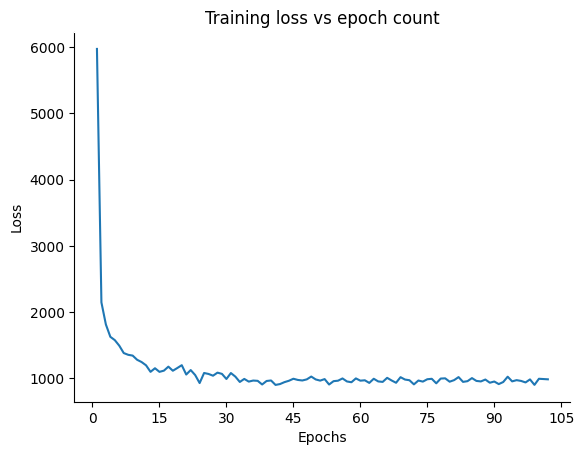

In [335]:
loss_epoch_plot(det_tr_losses, "Training loss vs epoch count")

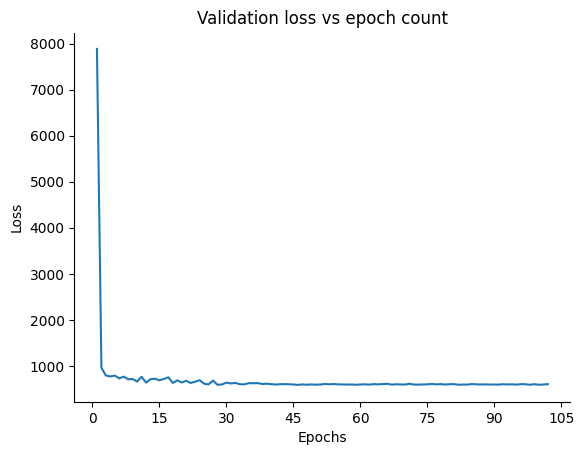

In [336]:
loss_epoch_plot(det_val_losses, "Validation loss vs epoch count")

### Testing

[ 42 208 430 596]


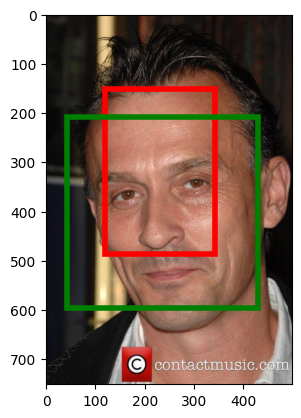

[153  65 339 251]


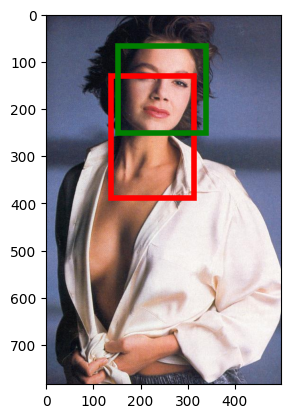

[378 118 691 431]


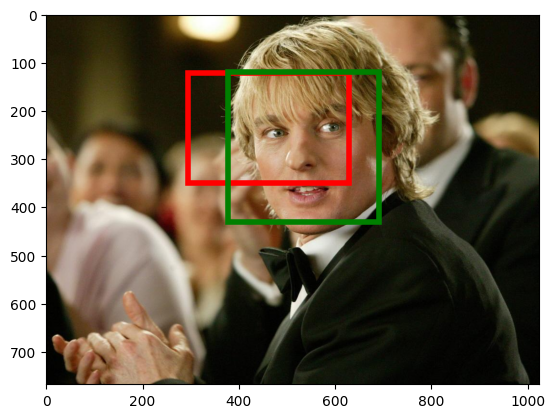

[ 96  18 199 121]


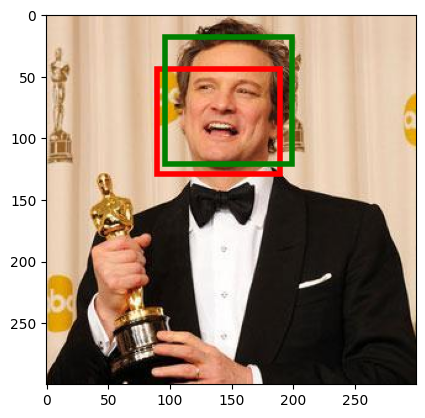

[218 303 548 633]


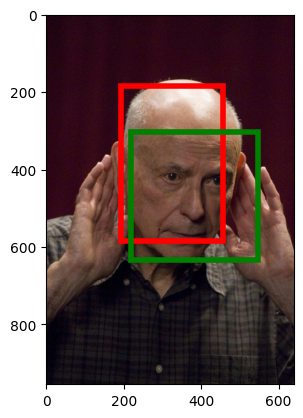

[218  88 352 222]


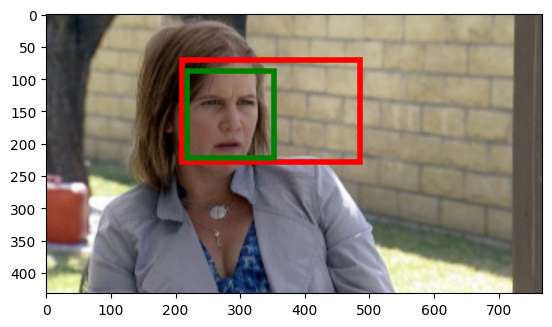

In [337]:
for image_name, target in det_test_data:
    with Image.open(images_path + image_name) as image:
        fig, ax = plt.subplots()
        ax.imshow(image)
        print(target)
        output = detection.predict(image)
        pred_fb = patches.Rectangle((output[0], output[1]), output[2]-output[0], output[3]-output[1], 
                               linewidth=4, edgecolor='red', facecolor='none')
        fb = patches.Rectangle((target[0], target[1]), target[2]-target[0], target[3]-target[1], 
                               linewidth=4, edgecolor='green', facecolor='none')
        ax.add_patch(pred_fb)
        ax.add_patch(fb)
        plt.show()

### Saving the model

In [338]:
torch.save(detection.state_dict(), 'detection_model.pt')

## The Recognition model

### The Data

In [339]:
class RecognitionData(Dataset):
    # the data is in the form [img_name, identity]
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, id, boundary = self.data[idx]
        with Image.open(images_path + image_name) as image:
            image = image.convert('RGB')
            image = image.crop(boundary)
            if self.transform:
                image = self.transform(image)
            id = torch.tensor(id, dtype=torch.float32)
            return image, id

In [340]:
rec_train_data, rec_val_data, rec_test_data = random_split(recognition_data, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(42))

train_dataset2 = RecognitionData(rec_train_data, rec_tr_transform)
val_dataset2 = RecognitionData(rec_val_data, rec_val_transform)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size)

### The Layers

In [341]:
recognition_cnn_layers = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
recognition_fc_layers = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(25088, 32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(32, 81), # 1-80 are ids + (-1) are 81 identities
    nn.Softmax(0)
)

### Model creation and training

In [342]:
recognition = CNN(recognition_cnn_layers, recognition_fc_layers, 'recognition').to(device)
print(recognition)

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Batch

In [343]:
# recognition.load_state_dict(torch.load('recognition_model.pt'))

In [344]:
print(sum(p.numel() for p in recognition.parameters()))

903441


In [ ]:
loss2 = nn.CrossEntropyLoss()
rec_tr_losses, rec_val_losses = recognition.training_loop(train_loader2, val_loader2, epochs, loss2, lr)

### Plots

In [ ]:
loss_epoch_plot(rec_tr_losses, "Training loss vs epoch count")

In [ ]:
loss_epoch_plot(rec_val_losses, "Validation loss vs epoch count")

### Testing

In [348]:
good = 0
bad = 0
impostors = 0
for image_name, id, boundary in rec_train_data:
    with Image.open(images_path + image_name) as image:
        image = image.convert('RGB')
        image = image.crop(boundary)
        if id == 0:
            target = -1
        else:
            target = id
        output = recognition.predict(image)

        if output == target:
            good += 1
        else:
            bad += 1

        if output == -1:
            impostors += 1

print(good, bad)
print(impostors)

123 436
559


### Saving the model

In [349]:
torch.save(recognition.state_dict(), 'recognition_model.pt')